In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import time
import os
import numpy as np

import torchvision
from torchvision import datasets, models
import matplotlib.pyplot as plt

In [3]:


import torch
import torch.nn as nn

class CustomCNN(nn.Module):
    def __init__(self, num_classes=6):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(256 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 256)
        self.dropout = nn.Dropout(p=0.8)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)  # Flattening the tensor
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [4]:
class ModifiedResNet(nn.Module):
    def __init__(self, num_classes=6):
        super(ModifiedResNet, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        in_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(in_features, 256)

    def forward(self, x):
        x = self.resnet(x)
        return x


In [5]:
class CombinedModel(nn.Module):
    def __init__(self, num_classes=6):
        super(CombinedModel, self).__init__()
        self.custom_cnn = CustomCNN(num_classes)
        self.modified_resnet = ModifiedResNet(num_classes)
        self.fc = nn.Linear(256 * 2, num_classes)

    def forward(self, x):
        custom_out = self.custom_cnn(x)
        resnet_out = self.modified_resnet(x)
        combined_out = torch.cat((custom_out, resnet_out), dim=1)
        out = self.fc(combined_out)
        return out

In [6]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

#connecting to GPU to be faster
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


#functions below are mostly from lab2/lab3 of APS360
def evaluate(net, loader, criterion):
    net.eval()
    total_loss = 0.0
    total_err = 0.0
    total_correct = 0
    total_samples = 0
    with torch.no_grad():
        for i, data in enumerate(loader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs, 1)
            total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)
            total_loss += loss.item()
            total_err += (predicted != labels).sum().item()
    accuracy = total_correct / total_samples
    err = float(total_err) / total_samples
    loss = float(total_loss) / (i + 1)
    return accuracy, err, loss


def loader(train_images, val_images, test_images, batch_size=64):
    train_loader = torch.utils.data.DataLoader(train_images, batch_size=batch_size, num_workers=2, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_images, batch_size=batch_size, num_workers=2, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_images, batch_size=batch_size, num_workers=2, shuffle=True)
    return train_loader, val_loader, test_loader

def train(model, train_images, val_images, test_images, batch_size=64, lr=0.001, num_epochs=30):
    torch.manual_seed(10)

    # Move the model to GPU
    model.to(device)

    train_loader, val_loader, test_loader = loader(train_images, val_images, test_images, batch_size)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)

    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    train_acc = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    val_acc = np.zeros(num_epochs)

    start_time = time.time()
    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0.0
        total_train_err = 0.0
        total_train_correct = 0
        total_train_samples = 0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.long()

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs, 1)
            total_train_correct += (predicted == labels).sum().item()
            total_train_samples += labels.size(0)
            total_train_loss += loss.item()
            total_train_err += (predicted != labels).sum().item()

        train_acc[epoch] = total_train_correct / total_train_samples
        train_err[epoch] = float(total_train_err) / total_train_samples
        train_loss[epoch] = float(total_train_loss) / (i + 1)
        val_acc[epoch], val_err[epoch], val_loss[epoch] = evaluate(model, val_loader, criterion)

        print(f"Epoch {epoch + 1}: Train Acc: {train_acc[epoch]:.4f}, Train err: {train_err[epoch]:.4f}, Train loss: {train_loss[epoch]:.4f} | Validation Acc: {val_acc[epoch]:.4f}, Validation err: {val_err[epoch]:.4f}, Validation loss: {val_loss[epoch]:.4f}")

        #savve model every few seconds
        if (epoch + 1) % 5 == 0 or (epoch + 1) == num_epochs:
            model_path = f"model_{model.__class__.__name__}_bs{batch_size}_lr{lr}_epoch{epoch + 1}.pth"
            torch.save(model.state_dict(), model_path)

    print('Finished Training')
    elapsed_time = time.time() - start_time
    print(f"Total time elapsed: {elapsed_time:.2f} seconds")

    epochs = np.arange(1, num_epochs + 1)
    np.savetxt(f"{model.__class__.__name__}_train_acc.csv", train_acc)
    np.savetxt(f"{model.__class__.__name__}_train_err.csv", train_err)
    np.savetxt(f"{model.__class__.__name__}_train_loss.csv", train_loss)
    np.savetxt(f"{model.__class__.__name__}_val_acc.csv", val_acc)
    np.savetxt(f"{model.__class__.__name__}_val_err.csv", val_err)
    np.savetxt(f"{model.__class__.__name__}_val_loss.csv", val_loss)


In [7]:
###########      Plotting data from lab2        #############

def plot_training_curve(path):
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()


In [8]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(),      #flipping and normalizing images to have an even more diverse dataset
    transforms.RandomCrop(64, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_images = datasets.ImageFolder('/content/drive/MyDrive/aps360/Processed Data/training_database/wheat', transform=transform)
val_images = datasets.ImageFolder('/content/drive/MyDrive/aps360/Processed Data/validation_database/wheat', transform=transform)
test_images = datasets.ImageFolder('/content/drive/MyDrive/aps360/Processed Data/testing_database/wheat', transform=transform)

In [9]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# Check for GPU availability and set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#functions below are the ones used in lab2/lab3 of APS360
def evaluate(net, loader, criterion):
    net.eval()
    total_loss = 0.0
    total_err = 0.0
    total_correct = 0
    total_samples = 0
    with torch.no_grad():
        for i, data in enumerate(loader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs, 1)
            total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)
            total_loss += loss.item()
            total_err += (predicted != labels).sum().item()
    accuracy = total_correct / total_samples
    err = float(total_err) / total_samples
    loss = float(total_loss) / (i + 1)
    return accuracy, err, loss


def loader(train_images, val_images, test_images, batch_size=64):
    train_loader = torch.utils.data.DataLoader(train_images, batch_size=batch_size, num_workers=2, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_images, batch_size=batch_size, num_workers=2, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_images, batch_size=batch_size, num_workers=2, shuffle=True)
    return train_loader, val_loader, test_loader

def train(model, train_images, val_images, test_images, batch_size=64, lr=0.001, num_epochs=30):
    torch.manual_seed(10)

    # Move the model to GPU
    model.to(device)

    train_loader, val_loader, test_loader = loader(train_images, val_images, test_images, batch_size)
    criterion = nn.CrossEntropyLoss()
    #optimizer = optim.Adam(model.parameters(), lr=lr)
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    train_acc = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    val_acc = np.zeros(num_epochs)

    start_time = time.time()
    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0.0
        total_train_err = 0.0
        total_train_correct = 0
        total_train_samples = 0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.long()

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs, 1)
            total_train_correct += (predicted == labels).sum().item()
            total_train_samples += labels.size(0)
            total_train_loss += loss.item()
            total_train_err += (predicted != labels).sum().item()

        train_acc[epoch] = total_train_correct / total_train_samples
        train_err[epoch] = float(total_train_err) / total_train_samples
        train_loss[epoch] = float(total_train_loss) / (i + 1)
        val_acc[epoch], val_err[epoch], val_loss[epoch] = evaluate(model, val_loader, criterion)

        print(f"Epoch {epoch + 1}: Train Acc: {train_acc[epoch]:.4f}, Train err: {train_err[epoch]:.4f}, Train loss: {train_loss[epoch]:.4f} | Validation Acc: {val_acc[epoch]:.4f}, Validation err: {val_err[epoch]:.4f}, Validation loss: {val_loss[epoch]:.4f}")

        # Save the model
        model_path = f"model_{model.__class__.__name__}_bs{batch_size}_lr{lr}_epoch{epoch + 1}.pth"
        torch.save(model.state_dict(), model_path)

    print('Finished Training')
    elapsed_time = time.time() - start_time
    print(f"Total time elapsed: {elapsed_time:.2f} seconds")

    epochs = np.arange(1, num_epochs + 1)
    np.savetxt(f"{model.__class__.__name__}_train_acc.csv", train_acc)
    np.savetxt(f"{model.__class__.__name__}_train_err.csv", train_err)
    np.savetxt(f"{model.__class__.__name__}_train_loss.csv", train_loss)
    np.savetxt(f"{model.__class__.__name__}_val_acc.csv", val_acc)
    np.savetxt(f"{model.__class__.__name__}_val_err.csv", val_err)
    np.savetxt(f"{model.__class__.__name__}_val_loss.csv", val_loss)


In [10]:
name = "combined"
batch_size = 256
learning_rate = 0.0005
epoch = 200

In [11]:
model2 = CombinedModel(num_classes = 6)
train(model2, train_images,val_images, test_images,batch_size=256, lr=0.0005, num_epochs=140) #

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 188MB/s]


Epoch 1: Train Acc: 0.4833, Train err: 0.5167, Train loss: 1.2768 | Validation Acc: 0.6476, Validation err: 0.3524, Validation loss: 1.7051
Epoch 2: Train Acc: 0.8334, Train err: 0.1666, Train loss: 0.4856 | Validation Acc: 0.7000, Validation err: 0.3000, Validation loss: 3.0911
Epoch 3: Train Acc: 0.8696, Train err: 0.1304, Train loss: 0.3872 | Validation Acc: 0.6357, Validation err: 0.3643, Validation loss: 4.7931
Epoch 4: Train Acc: 0.8949, Train err: 0.1051, Train loss: 0.3100 | Validation Acc: 0.6952, Validation err: 0.3048, Validation loss: 2.0216
Epoch 5: Train Acc: 0.9201, Train err: 0.0799, Train loss: 0.2349 | Validation Acc: 0.7405, Validation err: 0.2595, Validation loss: 1.1001
Epoch 6: Train Acc: 0.9386, Train err: 0.0614, Train loss: 0.1899 | Validation Acc: 0.7524, Validation err: 0.2476, Validation loss: 0.9150
Epoch 7: Train Acc: 0.9433, Train err: 0.0567, Train loss: 0.1583 | Validation Acc: 0.7857, Validation err: 0.2143, Validation loss: 0.8068
Epoch 8: Train Acc: 

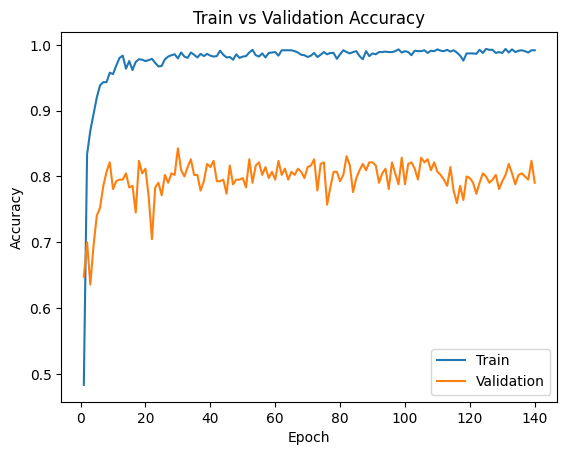

In [12]:
def plot_acc():
    import matplotlib.pyplot as plt
    train_acc = np.loadtxt("/content/CombinedModel_train_acc.csv")
    val_acc = np.loadtxt("/content/CombinedModel_val_acc.csv")
    plt.title("Train vs Validation Accuracy")
    n = len(train_acc) # number of epochs
    plt.plot(range(1,n+1), train_acc, label="Train")
    plt.plot(range(1,n+1), val_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()
plot_acc()

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CombinedModel(num_classes=6)
model.load_state_dict(torch.load('/content/model_CombinedModel_bs256_lr0.0005_epoch30.pth', map_location=device))
model.to(device)
model.eval()

CombinedModel(
  (custom_cnn): CustomCNN(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (fc1): Linear(in_features=16384, out_features=512, bias=True)
    (fc2): Linear(in_features=512, out_features=256, bias=True)
    (dropout): Dropout(p=0.8, inplace=False)
  )
  (modified_resnet): ModifiedResNet(
    (resnet): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 6

In [14]:
train_loader, val_loader, test_loader = loader(train_images, val_images, test_images, 256)
criterion = nn.CrossEntropyLoss()
accuracy, err, loss = evaluate(model, test_loader, criterion)
print(f'Accuracy: {accuracy:.4f}, Error: {err:.4f}, Loss: {loss:.4f}')

Accuracy: 0.8605, Error: 0.1395, Loss: 0.6607


In [18]:
from PIL import Image
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

# Function to make a prediction
def predict_image(image_path, model, transform, device):
    image = Image.open(image_path).convert('RGB')
    image = transform(image) #crop image
    image = image.unsqueeze(0)
    image = image.to(device)

    with torch.no_grad():
        output = model(image)
        _, predicted_label = torch.max(output, 1)

    return predicted_label.item()

class_names = train_images.classes
print("Class names:", class_names)

def get_label_name(label):
    return class_names[label]

Class names: ['Wheat_train_brown_rust', 'Wheat_train_healthy', 'Wheat_train_loose_smut', 'Wheat_train_powdered_mildew', 'Wheat_train_septoria', 'Wheat_train_yellow_rust']


Predicted label: 0
Wheat_train_brown_rust


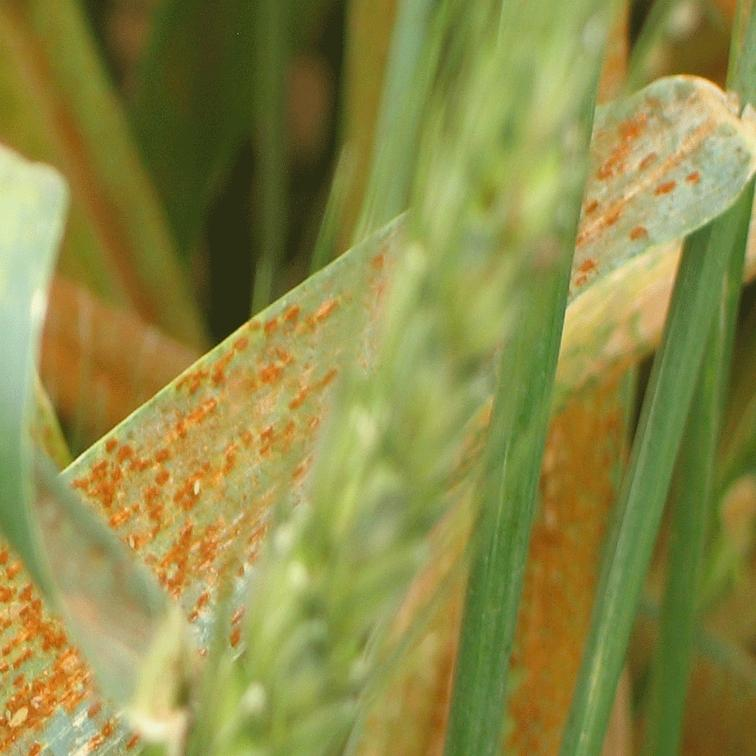

In [21]:


#using brown rust image
image_path = '/content/drive/MyDrive/aps360/Processed Data/testing_database/wheat/Wheat_test_brown_rust/wheat_brown_rust_10.jpg'
predicted_label = predict_image(image_path, model, transform, device)
print("Predicted label:", predicted_label)
print(get_label_name(predicted_label))
Image.open(image_path)